In [1]:
from pathlib import Path


fname = Path("sep_2021.nc4").absolute()

In [2]:
import cf_xarray
import xarray as xr


ds = xr.open_dataset(fname, drop_variables="time_bounds")
ds

<xarray.Dataset>
Dimensions:         (Layer: 8, LayerInterf: 9, time: 721, m: 181, n: 218,
                     grid_m: 182, grid_n: 219, bounds4: 4)
Coordinates:
  * Layer           (Layer) float32 -0.0625 -0.1875 -0.3125 ... -0.8125 -0.9375
  * LayerInterf     (LayerInterf) float32 0.0 -0.125 -0.25 ... -0.75 -0.875 -1.0
    latitude        (m, n) float32 ...
    longitude       (m, n) float32 ...
  * m               (m) float32 -48.87 -48.87 -48.86 ... -47.1 -47.09 -47.09
  * n               (n) float32 -28.62 -28.62 -28.61 ... -26.48 -26.47 -26.47
  * time            (time) datetime64[ns] 2021-09-01 ... 2021-10-01
Dimensions without coordinates: grid_m, grid_n, bounds4
Data variables: (12/22)
    Ri              (time, LayerInterf, m, n) float32 ...
    area            (m, n) float32 ...
    density         (time, Layer, m, n) float32 ...
    depth           (m, n) float32 ...
    diffusivity_z   (time, LayerInterf, m, n) float32 ...
    eps             (time, LayerInterf, m, n) float32 ...
    ...              ...
    velocity_x      (time, Layer, m, n) float32 ...
    velocity_y      (time, Layer, m, n) float32 ...
    velocity_z      (time, Layer, m, n) float32 ...
    viscosity_z     (time, LayerInterf, m, n) float32 ...
    waterlevel      (time, m, n) float32 ...
    zactive         (m, n) float32 ...
Attributes: (12/25)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Fri Aug 12 12:14:07 2022: ncks -4 -L 1 sep...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    NCO:                           netCDF Operators version 5.1.0 (Homepage =...

In [3]:
variables = [
    "grid_longitude",
    "grid_latitude",
    "k",
    "grid_depth",
    "depth",
    "zactive",
    "area",
    "waterlevel",
    "velocity_x",
    "velocity_y",
#     "velocity_omega",
    "velocity_z",
#     "tau_x",
#     "tau_y",
#     "density",
    "salinity",
    "temperature",
#     "tke",
#     "eps",
#     "viscosity_z",
#     "diffusivity_z",
#     "Ri",
]

subset = ds[variables]#.isel({"Layer": 0})  # just the surface

In [4]:
import humanize


print(f"Tamanho dos dados originais {humanize.naturalsize(ds.nbytes)=}")
print(f"Apenas com as variáveis necessárias {humanize.naturalsize(subset.nbytes)=}")

Tamanho dos dados originais humanize.naturalsize(ds.nbytes)='12.0 GB'
Apenas com as variáveis necessárias humanize.naturalsize(subset.nbytes)='4.7 GB'


In [5]:
print(f"Start: {ds.cf['T'][0].to_numpy()}\nEnd: {ds.cf['T'][-1].to_numpy()}")

Start: 2021-09-01T00:00:00.000000000
End: 2021-10-01T00:00:00.000000000


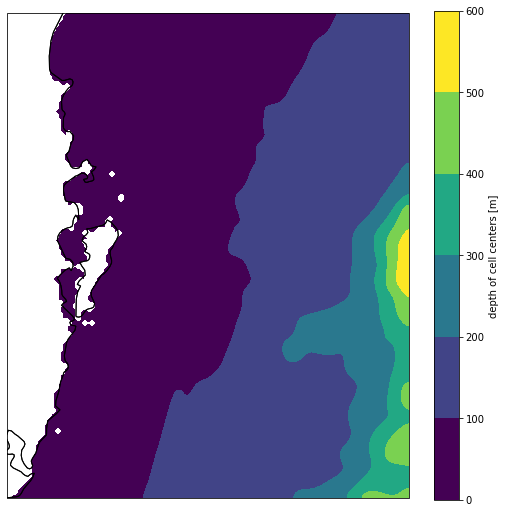

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


def creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        }
    )
    if bbox:
        ax.set_extent(bbox)
    ax.coastlines(resolution="10m")
    return fig, ax

fig, ax = creat_map()
subset.cf[["sea_floor_depth_below_sea_level"]]["depth"].T.plot.contourf(ax=ax)
ax.coastlines();

Let's check the first layer of the first day.

We need to convert the `ocean_sigma_coordinate` coordinate there to z later!

In [7]:
import numpy as np


def normalize_speed(u, v):
    u_norm = u / np.sqrt(u ** 2.0 + v ** 2.0)
    v_norm = v / np.sqrt(u ** 2.0 + v ** 2.0)
    speed = (u ** 2 + v ** 2) ** 0.5
    return (u_norm, v_norm, speed)

In [8]:
subset = subset.sel({"time": "2021-09-01T00:00:00"}).isel({"Layer": 0})

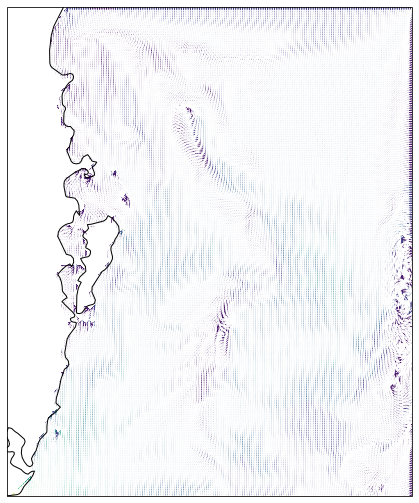

In [9]:
bbox = subset["m"].min(), subset["m"].max(), subset["n"].min(), subset["n"].max()
bbox = [v.to_numpy() for v in bbox]

u = subset.cf["eastward_sea_water_velocity"].squeeze()
v = subset.cf["northward_sea_water_velocity"].squeeze()

u_norm, v_norm, speed = normalize_speed(u, v)

fig, ax = creat_map(bbox=bbox)
ax.contourf(subset["longitude"], subset["latitude"], speed)
ax.quiver(subset["longitude"], subset["latitude"], u_norm, v_norm, color="white", scale=50);

In [10]:
def creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        }
    )
    if bbox:
        ax.set_extent(bbox)
    ax.coastlines(resolution="10m")
    return fig, ax

In [11]:
def convert_npdatetime2str(npdatetime):
    import pandas as pd
    ts = pd.to_datetime(str(npdatetime))
    return ts.strftime("%Y-%m-%d %H:%M:%S")

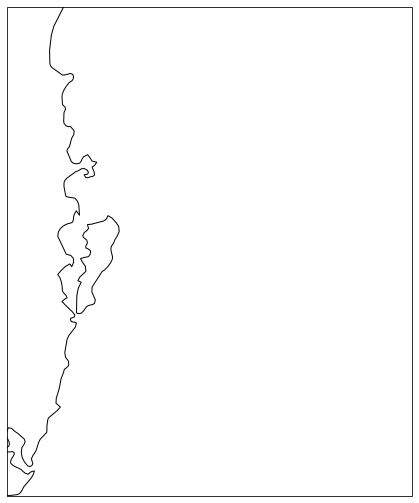

In [12]:
fig, ax = creat_map(bbox=bbox, figsize=(9, 9));

In [13]:
from xmovie import Movie


def custom_plot_function(ds, fig, tt, *args, **kwargs):
    ax = fig.gca()
    vmin, vmax =-1.5, 1.9  # Data min/max but we will less to highligh the tides inside the bays.
    ds.isel(time=tt).plot(ax=ax, vmin=-0.5, vmax=0.5, cmap="RdBu_r")

    npdatetime = ds["time"][tt].to_numpy()
    title = convert_npdatetime2str(npdatetime)
    ax.set_title(title)
    return None, None


chunked = ds.cf["sea_surface_height"].T.chunk({'time':1})
mov = Movie(chunked, custom_plot_function)

/home/filipe/micromamba/envs/PARCELS/lib/python3.10/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/filipe/micromamba/envs/PARCELS/lib/python3.10/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


## Check first time steps

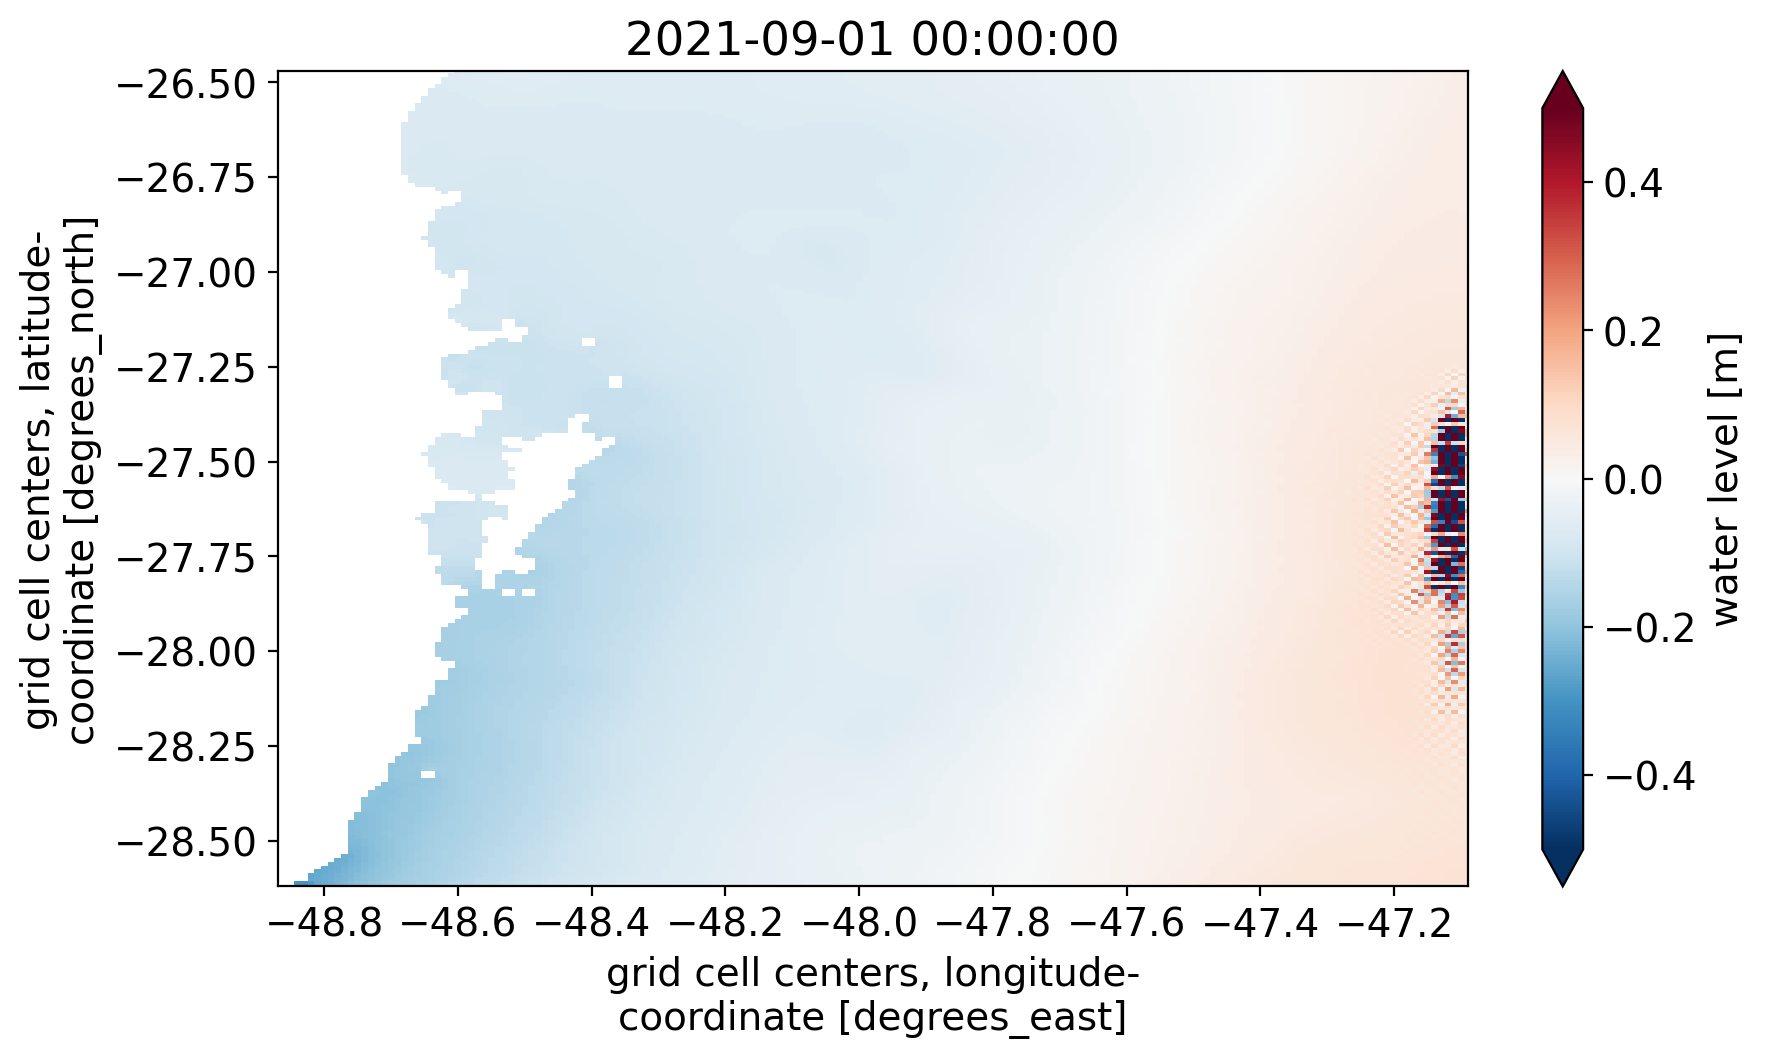

In [14]:
mov.preview(0)  # first hour

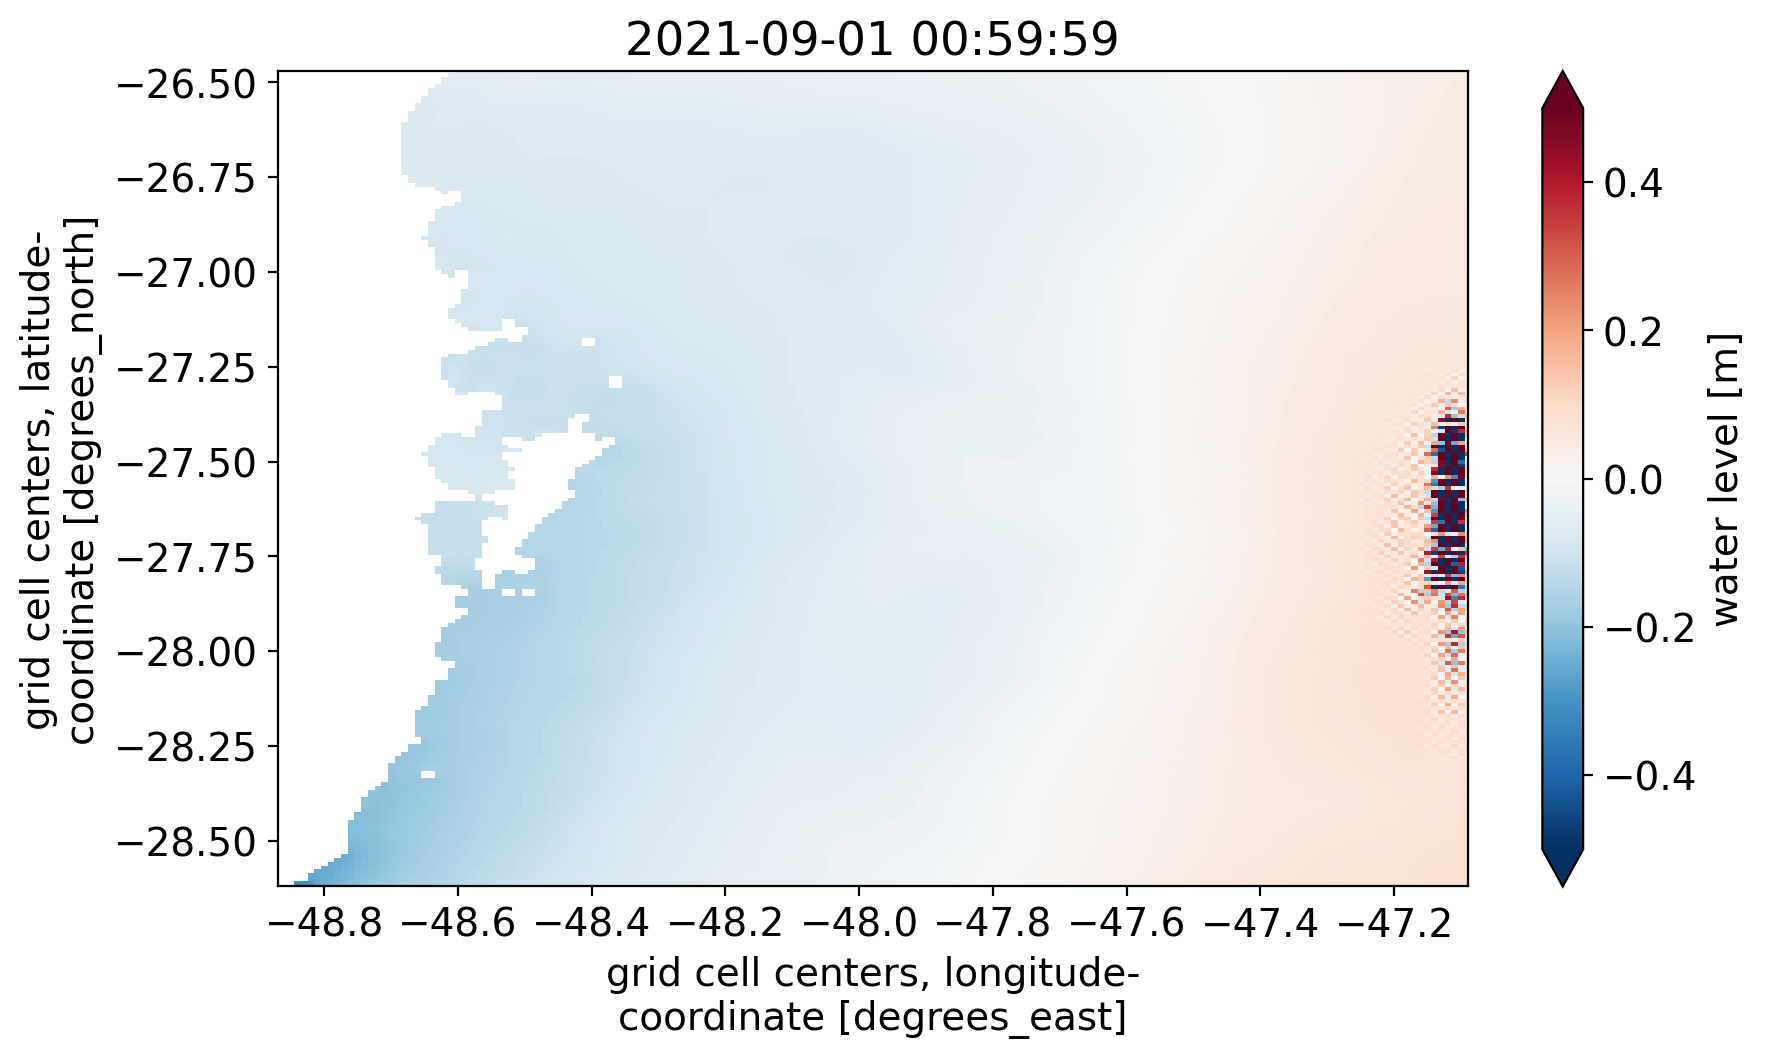

In [15]:
mov.preview(1)  # second hour

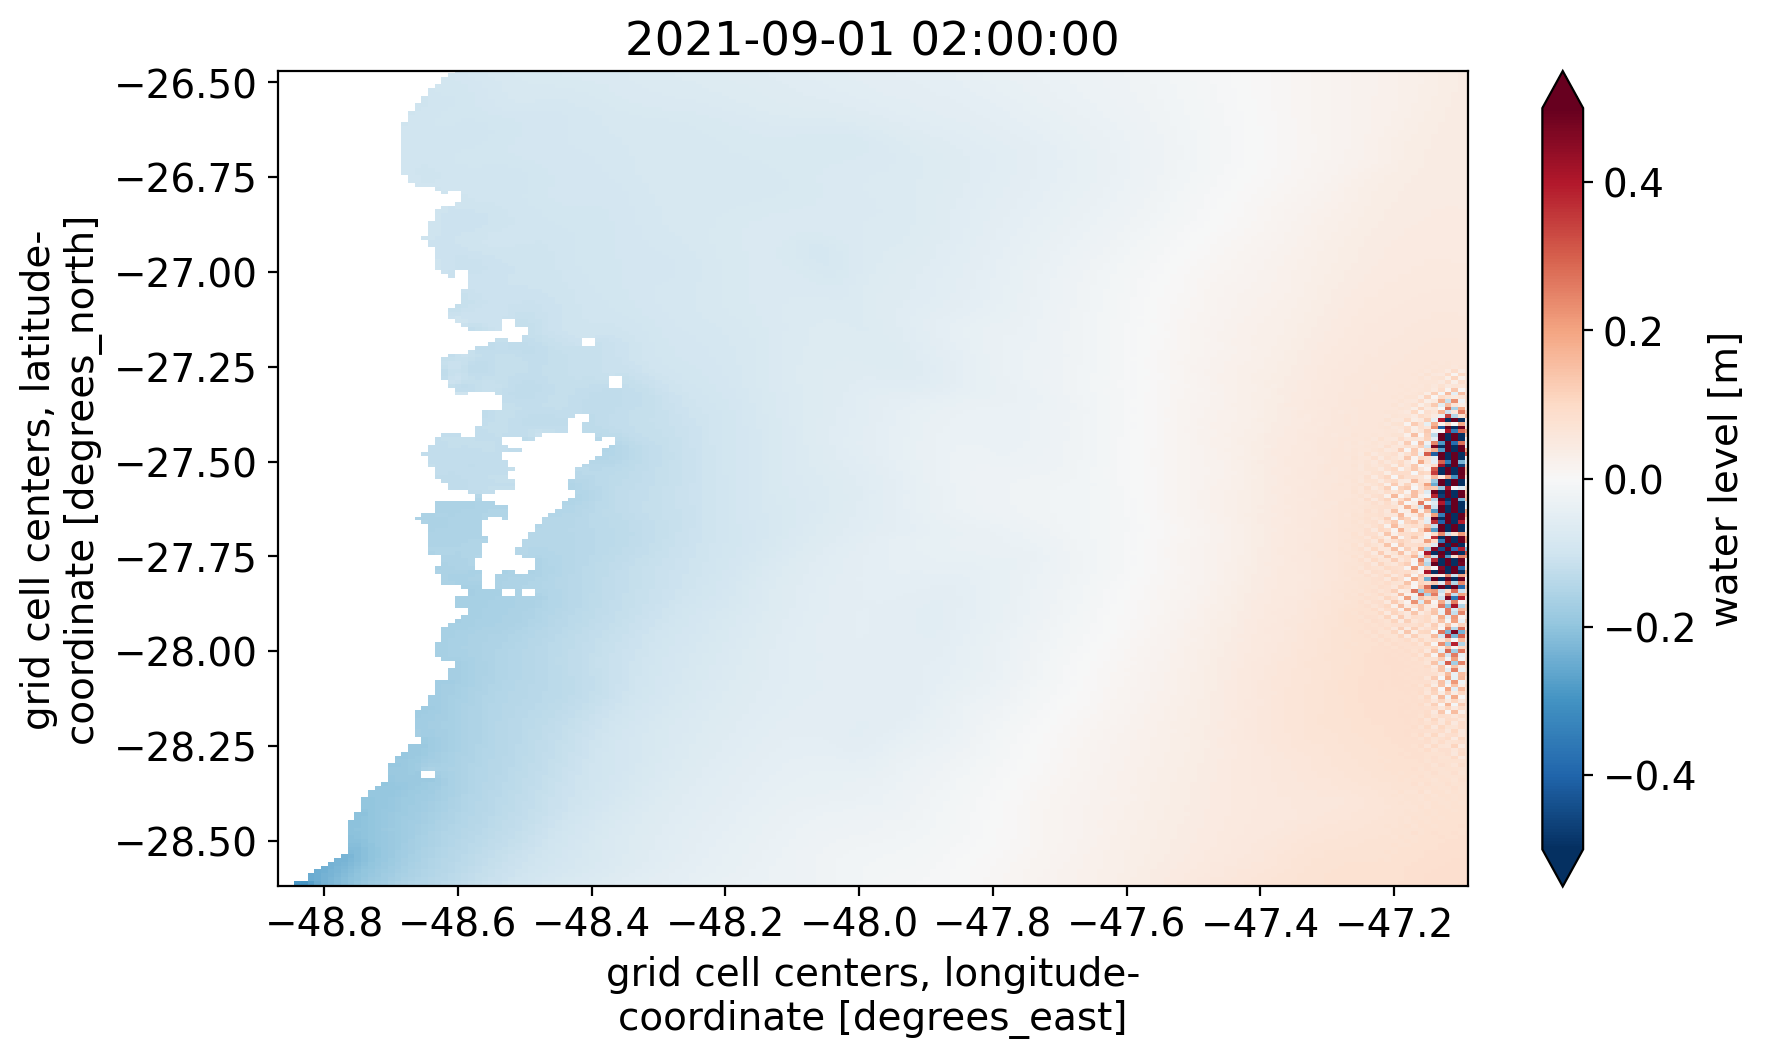

In [16]:
mov.preview(2)  # third hour

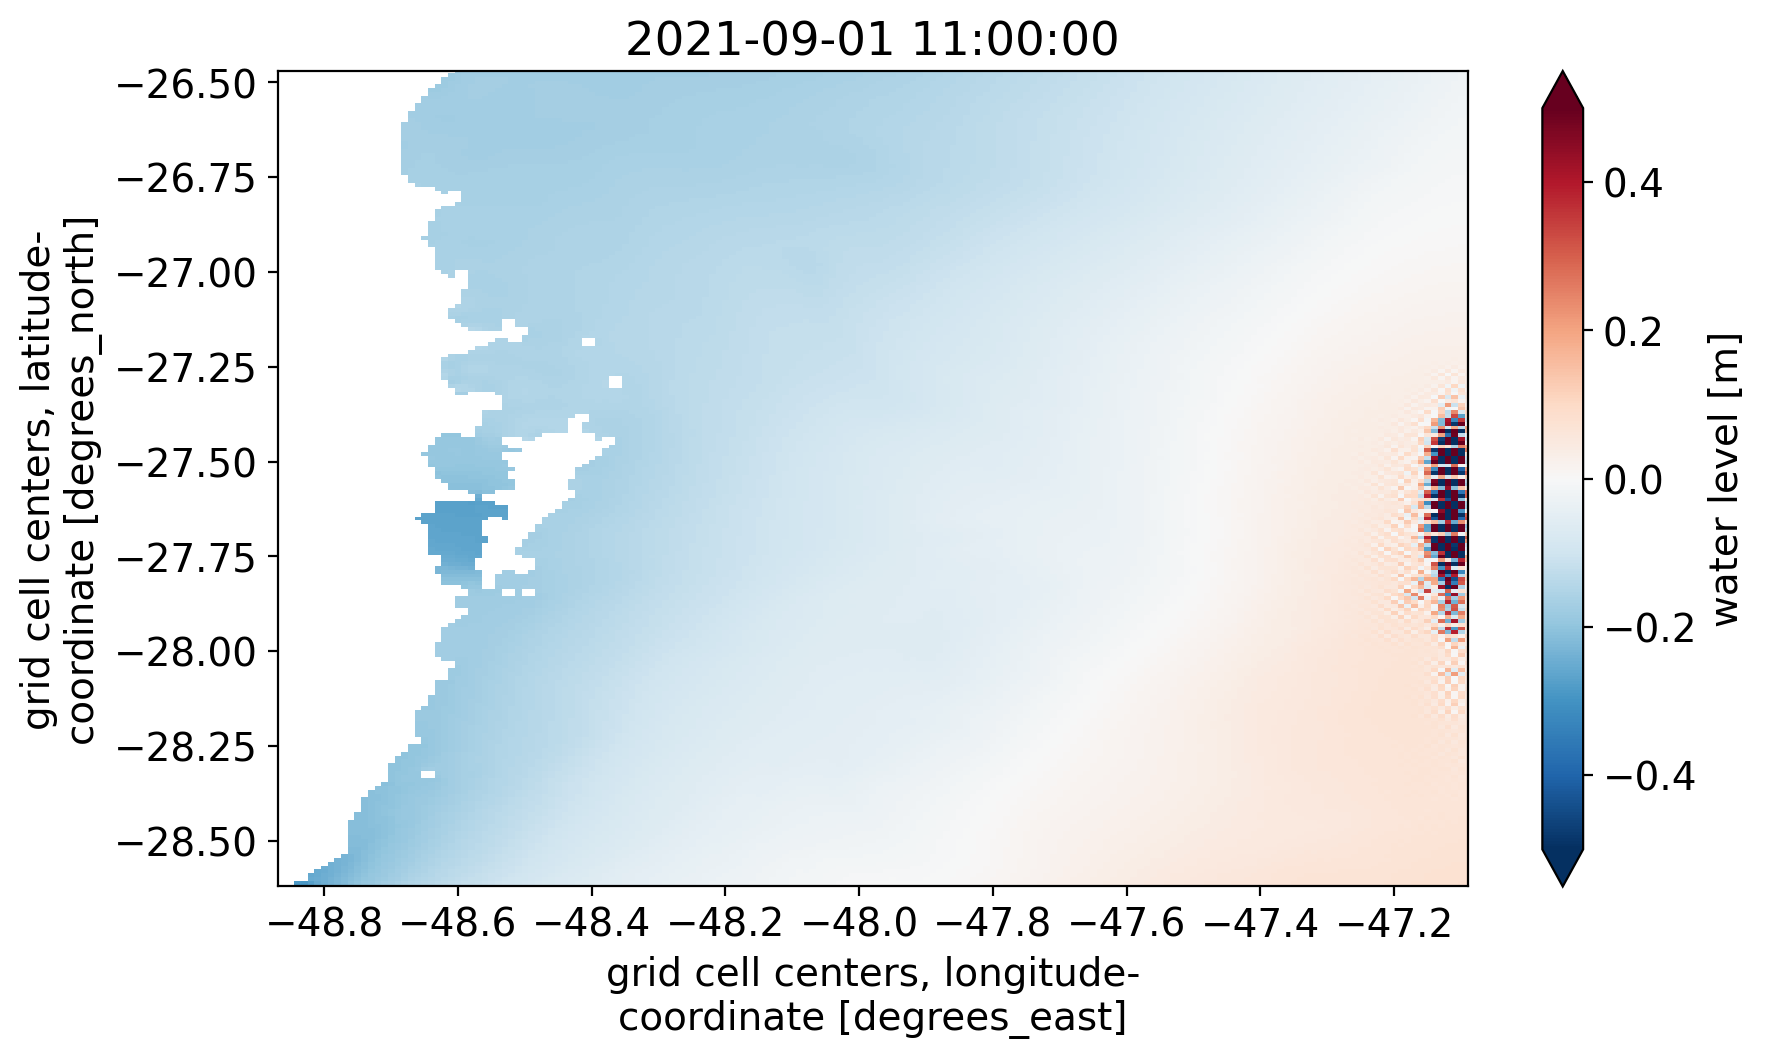

In [17]:
mov.preview(11)  # twelfth hour

## Render movie

In [18]:
filename = f"{fname.stem}.mp4"


mov.save(
    filename=filename,
    progress=True,
    parallel=True,
    parallel_compute_kwargs={"scheduler": "processes", "num_workers": 3},
    overwrite_existing=True,
)

Movie created at sep_2021.mp4


In [19]:
from IPython.display import HTML


HTML(f"""
    <video alt="test" controls style="outline:none; width:70%; height:70%;">
        <source src="{filename}" type="video/mp4">
    </video>
""")